In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
data = pd.read_csv('fer2013.csv')

In [3]:
data.shape
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [5]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


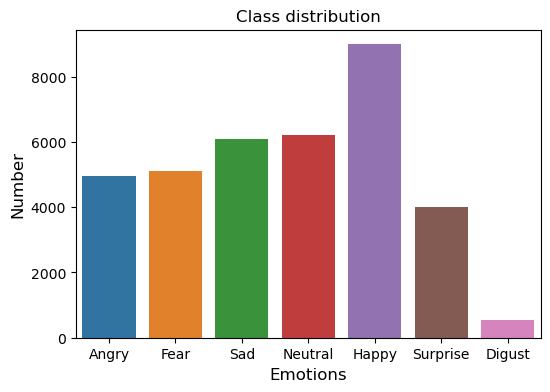

In [6]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

C:\Users\vijay\AppData\Local\Temp\ipykernel_8940\2731323236.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


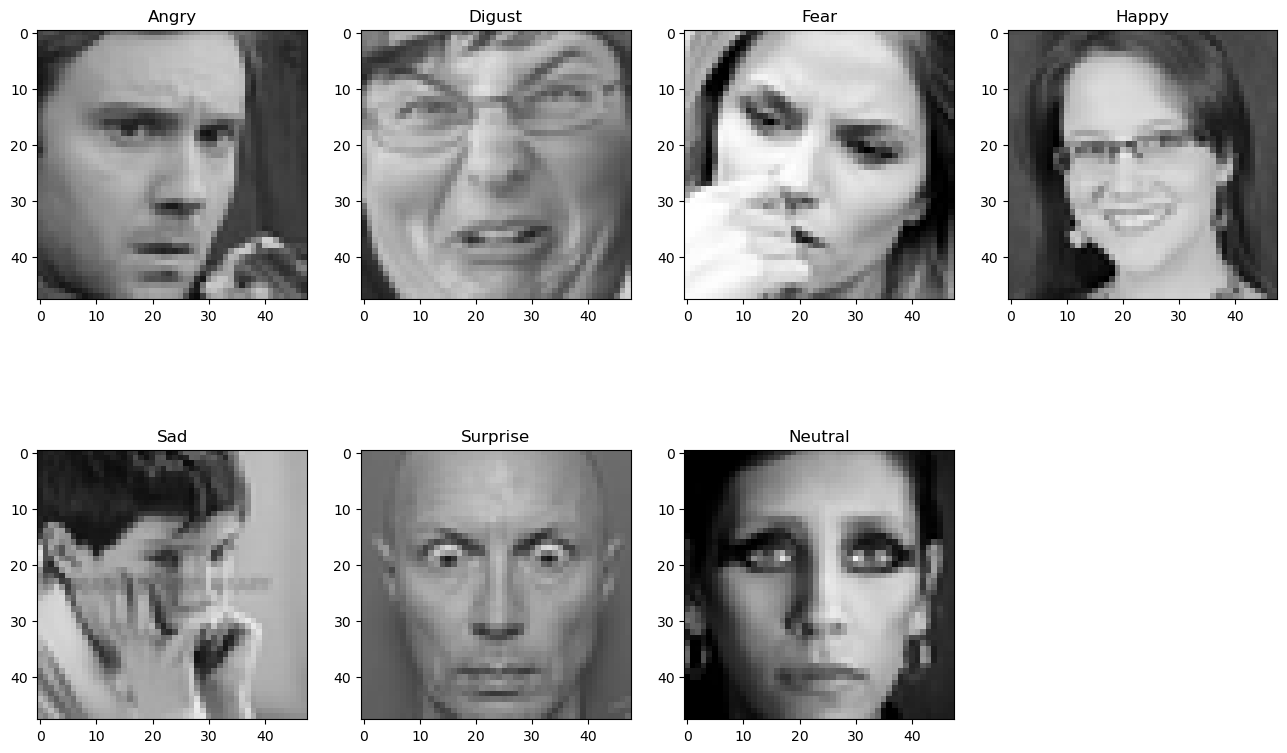

In [7]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [8]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#data_train = data_train[data_train['emotion']!=1]
#data_val = data_val[data_val['emotion']!=1]
##data_test = data_test[data_test['emotion']!=1]
#data_train['emotion'] = data_train['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_test['emotion'] = data_test['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_val['emotion'] = data_val['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [ ]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [ ]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

In [ ]:
import cv2
data_path = "C:\\Users\\vijay\\Downloads\\archive(6)\\CK+48"
data_dir_list = os.listdir(data_path)

img_data_list=[]

numbers = []
c=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        input_img_resize = np.reshape(input_img_resize,(48,48,1))
        img_data_list.append(input_img_resize)
        c += 1
    numbers.append(c)
    c = 0
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

In [ ]:
pl = img_data
np.reshape(pl[0],(48,48,1))
pl[0].shape

In [ ]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=6 #54
labels[189:365]=1 #177
labels[366:440]=2 #75
labels[441:647]=3 #207
labels[648:731]=4 #84
labels[732:980]=5 #249

names = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def getLabel(id):
    return ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]

In [ ]:
from tensorflow.keras.utils import  to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Y = to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(48, 48, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2,3, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, t)

    return model

#output layer
#model.add(Dense(6,activation='softmax'))

In [ ]:
pip install stn

In [ ]:
from tensorflow import keras
from keras import layers
from stn import spatial_transformer_network as transformer

img_inputs = keras.Input(shape=(48,48,1))

locnet = layers.Conv2D(32,3, padding='same')(img_inputs)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(64,3, padding='same')(locnet)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(96,3, padding='same')(locnet)
feat_map = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Flatten()(feat_map)
locnet = layers.Dense(90, activation='relu',kernel_regularizer='l2')(locnet)
locnet = layers.Dropout(0.2)(locnet)
locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
theta = layers.Dense(6, activation='linear')(locnet)

locnet = keras.Model(img_inputs, theta, name="locnet")
#locnet.summary()

#spatial transformer network
outstn = transformer(feat_map,theta)



#feature extraction network
fe = layers.Conv2D(32,3, padding='same')(img_inputs)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(64,3, padding='same')(fe)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(96,3, padding='same')(fe)
fe = layers.Activation('relu')(fe)
do = layers.BatchNormalization()(fe)

fe = keras.Model(img_inputs, do, name="feature extractor")
#fe.summary()

add = layers.Add()([outstn, do])

flats = layers.Flatten()(add)
flats = layers.Dense(64, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
flats = layers.Dense(32, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
#output = layers.Dense(6, activation='softmax')(flats)

x1 = layers.Dense(7, activation='linear')(flats)
x2 = layers.Dense(7,activation='linear')(flats)
x3 = layers.Dense(7,activation='linear')(flats)
x4 = layers.Dense(7,activation='linear')(flats)
avg = layers.Average()([x1, x2, x3, x4])
out = layers.Dense(7, activation='softmax')(avg)

model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=lr_schedule), 
              metrics=['accuracy'])

model.summary()

In [ ]:
import ghost.hdf5
import alpha.hdf5 as Eyebrow_distance

In [ ]:
if(ghost.keras.model (True, Maxpool):
   checkpoint = 0

In [ ]:
import threading
import random
from twilio.rest import Client

account_sid = 'AC1cbb5510c9a09fe576d293357dd4b76b'
auth_token = '3ed5835edd3b0287f1bbab1d3e34668c'
client = Client(account_sid, auth_token)
count = 5

def dreamer_now(stress_value):
    i = random.randint(1, 100)
    message_body = f"Here are a few happy songs to cheer you up:\n\n"
    for j in range(5):
        message_body += f"- {happy_songs[i + j]}\n"
    message = client.messages.create(
        from_ = 'whatsapp:+14155238886',
        body = message_body,
        to = 'whatsapp:+919551149200'
    )
    print(message.sid)


In [ ]:
happy_songs = {
1: "Twist and Shout - The Beatles",
2: "All You Need Is Love - The Beatles",
3: "A Hard Day's Night - The Beatles",
4: "Here Comes the Sun - The Beatles",
5: "Like a Rolling Stone - Bob Dylan",
6: "The Times They Are A-Changin' - Bob Dylan",
7: "Blowin' in the Wind - Bob Dylan",
8: "Lay Lady Lay - Bob Dylan",
9: "The Thrill Is Gone - BB King",
10: "Sweet Little Angel - BB King",
11: "Rock Me Baby - BB King",
12: "Everyday I Have the Blues - BB King",
13: "Walking on Sunshine - Katrina and the Waves",
14: "Don't Stop Believin' - Journey",
15: "I Wanna Dance with Somebody - Whitney Houston",
16: "Happy - Pharrell Williams",
17: "Uptown Funk - Mark Ronson ft. Bruno Mars",
18: "September - Earth, Wind & Fire",
19: "I'm a Believer - The Monkees",
20: "Celebration - Kool & The Gang",
21: "Dancing Queen - ABBA",
22: "Hey Ya! - OutKast",
23: "Can't Stop the Feeling! - Justin Timberlake",
24: "Girls Just Want to Have Fun - Cyndi Lauper",
25: "Shake It Off - Taylor Swift",
26: "I Will Survive - Gloria Gaynor",
27: "Good Vibrations - The Beach Boys",
28: "Wake Me Up Before You Go-Go - Wham!",
29: "I'm Still Standing - Elton John",
30: "All Star - Smash Mouth",
31: "You Make My Dreams - Hall & Oates",
32: "Sweet Caroline - Neil Diamond",
33: "What a Wonderful World - Louis Armstrong",
34: "Valerie - Mark Ronson ft. Amy Winehouse",
35: "Stayin' Alive - Bee Gees",
36: "Bohemian Rhapsody - Queen",
37: "I Want You Back - The Jackson 5",
38: "I Feel Good - James Brown",
39: "Mamma Mia - ABBA",
40: "Footloose - Kenny Loggins",
41: "Ain't No Mountain High Enough - Marvin Gaye & Tammi Terrell",
42: "Get Lucky - Daft Punk ft. Pharrell Williams",
43: "You Can't Hurry Love - The Supremes",
44: "Sweet Child O' Mine - Guns N' Roses",
45: "Kiss - Prince",
46: "Dancing in the Street - Martha & The Vandellas",
47: "Ain't No Sunshine - Bill Withers",
48: "Three Little Birds - Bob Marley",
49: "One Love - Bob Marley",
50: "Could You Be Loved - Bob Marley",
51: "Tum Se Hi - Jab We Met",
52: "Tere Bina - Guru",    
53: "Jai Ho - Slumdog Millionaire",
54: "Chaiyya Chaiyya - Dil Se",
55: "Kal Ho Naa Ho - Kal Ho Naa Ho",
56: "Kabhi Kabhi Mere Dil Mein - Kabhi Kabhie",
57: "Chand Sifarish - Fanaa",
58: "Kabhi Jo Baadal Barse - Jackpot",
59: "Tujh Mein Rab Dikhta Hai - Rab Ne Bana Di Jodi",
60: "Chhod Do Aanchal Zamana Kya Kahega - Paying Guest",
61: "Mere Sapno Ki Rani - Aradhana",
62: "Yeh Dosti - Sholay",
63: "Aaj Kal Tere Mere Pyaar Ke Charche - Brahmachari",
64: "Jab Koi Baat Bigad Jaye - Jurm",
65: "Ae Mere Humsafar - Qayamat Se Qayamat Tak",
66: "Kajra Re - Bunty Aur Babli",
67: "Jumma Chumma De De - Hum",
68: "Dilbar Dilbar - Sirf Tum",
69: "Mere Rashke Qamar - Baadshaho",
70: "Tamma Tamma Loge - Thanedaar",
71: "Dola Re Dola - Devdas",
72: "Mehendi Laga Ke Rakhna - Dilwale Dulhania Le Jayenge",
73: "Kuch Kuch Hota Hai - Kuch Kuch Hota Hai",
74: "Radha - Student of the Year",
75: "Cham Cham - Baaghi",
76: "Dil Chori - Sonu Ke Titu Ki Sweety",
77: "Hawa Hawa - Mubarakan",
78: "Aankh Marey - Simmba",
79: "Tum Hi Ho - Aashiqui 2",
80: "Dheere Dheere - Yo Yo Honey Singh",
81: "Munni Badnaam Hui - Dabangg",
82: "Sheila Ki Jawani - Tees Maar Khan",
83: "Chikni Chameli - Agneepath",
84: "Balam Pichkari - Yeh Jawaani Hai Deewani",
85: "Gandi Baat - R... Rajkumar",
86: "Lungi Dance - Chennai Express",
87: "Ghagra - Yeh Jawaani Hai Deewani",
88: "Tune Maari Entriyaan - Gunday",
89: "Ainvayi Ainvayi - Band Baaja Baaraat",
90: "Ae Papi - Kismat Konnection",
91: "Soni De Nakhre - Partner",
92: "Tu Mere Agal Bagal - Phata Poster Nikhla Hero",
93: "Kudi Nu Nachne De - Angrezi Medium",
94: "Milegi Milegi - Stree",
95: "Duniya Mein Aaye Ho Toh - Judwaa",
96: "Husn Hai Suhana - Coolie No. 1",
97: "O Saki Saki - Batla House",
98: "Hookah Bar - Khiladi 786",
99: "Billo Rani - Dhan Dhana Dhan Goal",
100: "Main Aisa Kyun Hoon - Lakshya"}    

In [ ]:
flag = 0

In [ ]:
flag = int(input("Enter 0 to play the video or 1 to access webcam"))

In [ ]:
print(type(flag))

In [ ]:
count = 0
from scipy.spatial import distance as dist
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.models import load_model


def eye_brow_distance(leye,reye):
    #global points
    distq = dist.euclidean(leye,reye)
    points.append(int(distq))
    return distq

def normalize_values(points,disp):
    normalized_value = abs(disp - np.min(points))/abs(np.max(points) - np.min(points))
    stress_value = np.exp(-(normalized_value))
    if stress_value>=50:
        stress_status = "Current Stress value"
    else:
        stress_status = "Current stress value"
    return stress_value, stress_status

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

if flag == 0:
    cap = cv2.VideoCapture('WhatsApp Video 2023-04-01 at 12.30.44 PM.mp4')
    print('0')    
if flag == 1:
    cap = cv2.VideoCapture(0)
    print('1')
points = []
while(True):
    _, frame = cap.read()
    frame = cv2.flip(frame, 1)
    frame = imutils.resize(frame, width = 500, height = 500)

    # preprocessing the image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    for detection in detections:
        x, y, w, h = detection

        leye = []
        reye = []
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.3, 5)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        for (ex,ey,ew,eh) in eyes:
            if ex < w/2:
                leye = (int(ex+ew/2+x), int(ey+eh/2+y))
                #cv2.circle(frame, leye, 2, (0, 0, 255), 2)
            else:
                reye = (int(ex+ew/2+x), int(ey+eh/2+y))
                #cv2.circle(frame, reye, 2, (0, 0, 255), 2)

        if leye and reye:

            disp = eye_brow_distance(leye,reye)
            stress_value, stress_status = normalize_values(points, disp)
            cv2.putText(frame, f"Stress value: {stress_value :.2f}", (x, y+h+30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)


            while count < 1:
                t1 = threading.Thread(target=dreamer_now, args=(stress_value,))
                t1.start()
                count += 1
                t1.join()





    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
